# ECE 539/COS 512, Fall 2021 - Code Demo 1 - Sources of Uncertainty

In this notebook, we demonstrate the effects of uncertainty as a result of **structured uncertainty**, **model complexity**, and **discretization**.

This notebook is read-only, so if you wish to experiment, feel free to add a copy of it to your own Google Drive to start making changes.

### Structured Uncertainty
Let's use the bicycle (car) model to see the effect of some drag terms. You can use the slider to adjust the amount of uncertainty and notice the effect on the trajectories. Click the play button at the top left of the code snippet to try out the current settings.

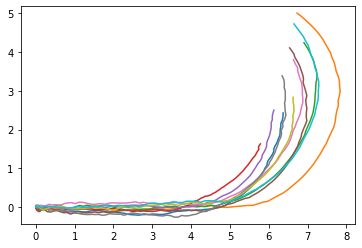

In [8]:
## Import things
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from scipy import integrate

## Car motion model
#   s (state) = [x, y, velocity magnitude, orientation]
#   u (controls) = [acceleration, steering angle]
#   d (disturbance) = [slip, drag]
def s_dot(t,s,u,d):
    acc,steering = u(t)
    slip,drag = d(t)
    pos_x_dot = s[2]*np.cos(s[3]) + slip*np.sin(s[3])
    pos_y_dot = s[2]*np.sin(s[3]) + slip*np.cos(s[3])
    vel_dot = acc - drag
    theta_dot = s[2]/b*np.tan(steering)
    return pos_x_dot,pos_y_dot,vel_dot,theta_dot

## Simulation settings
T_max = 10              #Trajectory duration
delta_t = .1            #Time resolution
b = 1.5                 #Car length (m)
n_traj = 10             #Number of different trajectories to generate
s_init = [0,0,0,0]      #Initial state
slip_weight = 0.2       # @param {type:"slider", min:0, max:1, step:0.1}
drag_weight = 0.2       # @param {type:"slider", min:0, max:1, step:0.1}
d_weight = [slip_weight,drag_weight]      #Weight of disturbances

## Define controls
u = lambda t: (.5*(1-(t>2)),.5*(t>5)) #accelerates until t=2, turns after t=5

## Sample a few different trajectories for different noise instantiations
for i in range(n_traj):
  # Sample and define noise
  sampled_noise = np.random.randn(int(T_max/delta_t),len(d_weight))*d_weight
  d = lambda t: sampled_noise[int(t/delta_t)-1,:]

  # Solve ODE
  results = integrate.solve_ivp(s_dot,t_span=(0,T_max),y0=s_init,
                                method='RK45',max_step=delta_t,args=(u,d))

  #Plot trajectory
  plt.plot(results['y'][0,:],results['y'][1,:])

plt.axis('equal')
plt.show()

### Model Complexity

Now let's explore the results of different model complexities.  
We'll be using two different models for the lateral motion of a quadrotor.

#### Simpler Model 1
$x = [s,v]$ &emsp; &emsp; &emsp;&emsp;&emsp;(position, velocity)  
$u = \theta$ &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;(control is the tilt angle of the quadrotor)  
$\dot{x} = [v,g\cdot \tan(\theta)]$ &emsp; (model dynamics, $g=9.81 m/s^2$)

#### Moder Detailed Model 2
$x = [s,v,\theta,\omega]$ &emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(position, velocity, angle, angle rate)  
$u = \Delta F$ &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;&emsp;&emsp;&emsp;&emsp;(control is difference in force applied from each motor)  
$\dot{x} = [v,g\cdot \tan(\theta),\omega,\kappa_\text{thrust}\cdot\Delta F]$ &emsp; (model dynamics, $\kappa_\text{thrust}$ depends on the quadrotor's physical parameters)

Notice how the quadrotor's acceleration changes instantaneously in Model 1. Think about what circumstances under which this may or may not be realistic. Play with the value of $\kappa_\text{thrust}$ and notice how it affects the disagreement between Models 1 and 2.

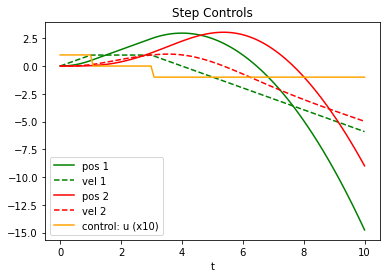

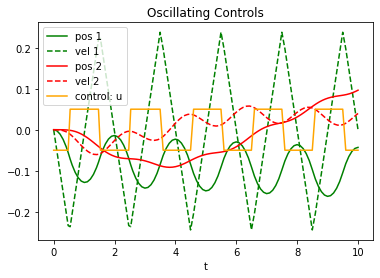

In [17]:
## Constants
g = 9.81              # gravity m/s^2
k_thrust = 1.0        # @param {type:"slider", min:0.1, max:2, step:0.1}
s_init_1 = [0,0]      # Initial values
s_init_2 = [0,0,0,0]  # Initial values
T_max = 10            # Trajectory duration
delta_t = 0.1         # Time resolution
k_P = 1.0             # Proportional Control Gain for Model 2
k_D = 1.0             # Derivative Control Gain for Model 2

## Simpler Model 1, with direct control over attitude angle.
def s_dot_1(t,s,u):
  pos_dot = s[1]
  vel_dot = g*np.tan(u(t))
  return pos_dot,vel_dot

## More Detailed Model 2, with a low-level attitude controller.
def s_dot_2(t,s,u):
  pos_dot = s[1]
  vel_dot = g*np.tan(s[2])
  ang_dot = s[3]
  # Low-level feedback control policy, attempts to mimic Model 1.
  u_thrust = k_P * (u(t) - s[2]) - k_D * s[3]
  ang_rate_dot = k_thrust * u_thrust
  return pos_dot,vel_dot,ang_dot,ang_rate_dot

## Define acceleration signals.
# This is a direct control input under Model 1, and a reference for a
# simple feedback control policy under Model 2.
u1 = lambda t: (1 - (t>1) - (t>3))*.1  # step-constant controls
u2 = lambda t: (.5 - (np.cos(np.pi*t)>0))*.1  # osclillating control
# u3 = lambda t:  ## experiment with your own control signal

u = u1

## Solve ODE.
model_1 = integrate.solve_ivp(s_dot_1,t_span=(0,T_max),y0=s_init_1,
                              method='RK45',max_step=delta_t,args=(u,))
model_2 = integrate.solve_ivp(s_dot_2,t_span=(0,T_max),y0=s_init_2,
                              method='RK45',max_step=delta_t,args=(u,))

## Plot
plt.plot(model_1['t'],model_1['y'][0,:],label='pos 1',c='green',ls='-')
plt.plot(model_1['t'],model_1['y'][1,:],label='vel 1',c='green',ls='--')
plt.plot(model_2['t'],model_2['y'][0,:],label='pos 2',c='red',ls='-')
plt.plot(model_2['t'],model_2['y'][1,:],label='vel 2',c='red',ls='--')
plt.plot(model_1['t'],10*u(model_1['t']),label='control: u (x10)',c='orange')
plt.legend()
plt.xlabel('t')
plt.title('Step Controls')

## Try with a different control (you can define your own above).
u = u2

## Solve ODE.
model_1 = integrate.solve_ivp(s_dot_1,t_span=(0,T_max),y0=s_init_1,
                              method='RK45',max_step=delta_t,args=(u,))
model_2 = integrate.solve_ivp(s_dot_2,t_span=(0,T_max),y0=s_init_2,
                              method='RK45',max_step=delta_t,args=(u,))

## Plot
plt.figure()
plt.plot(model_1['t'],model_1['y'][0,:],label='pos 1',c='green',ls='-')
plt.plot(model_1['t'],model_1['y'][1,:],label='vel 1',c='green',ls='--')
plt.plot(model_2['t'],model_2['y'][0,:],label='pos 2',c='red',ls='-')
plt.plot(model_2['t'],model_2['y'][1,:],label='vel 2',c='red',ls='--')
plt.plot(model_1['t'],u(model_1['t']),label='control: u',c='orange')
plt.legend()
plt.xlabel('t')
plt.title('Oscillating Controls')
plt.show()


### Discretization

Until now we've been using the Runge-Kutta ODE solver to find the solution trajectory given our specified dynamics and controls. Here we'll compare Runge-Kutta with the simple forward Euler method, and notice the errors that result from discretization.

Forward Euler: $x_{t+1} = x_t + f(t,x_t,u_t)\Delta t$  
*is a special case of*   
Runge-Kutta : $x_{t+1} = x_t + f_{adjusted}\Delta t$

Play with the time resolution and notice the error in the car dynamics for each of the solution methods.

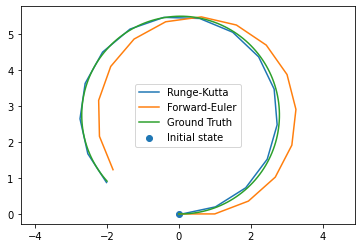

In [21]:
## Constants
T_max = 15            # Trajectory duration
delta_t = 1         # @param {type:"slider", min:0.1, max:2, step:0.1}
b = 1.5               # Car length
a, delta = 0, 0.5     # Controls: constant turning, no acceleration
s_init = [0,0,1,0]    # Initial state

## Car dynamics
s_dot = lambda t,s : (s[2]*np.cos(s[3]), s[2]*np.sin(s[3]), a, s[2]/b*np.tan(delta))

# Runge-Kutta
rk45 = integrate.solve_ivp(s_dot,t_span=(0,T_max),y0=s_init,
                              method='RK45',max_step=delta_t)
plt.plot(rk45['y'][0,:],rk45['y'][1,:],label='Runge-Kutta')

#Forward Euler
t_steps = int(T_max/delta_t)+1        #Number of discrete steps
s = np.zeros((len(s_init),t_steps))   #Place to store trajectory
s[:,0] = s_init                       #Initial state
for t in range(t_steps-1):
  s[:,t+1] = s[:,t] + delta_t*np.array(s_dot(t*delta_t,s[:,t]))
plt.plot(s[0,:],s[1,:],label='Forward-Euler')

#Ground truth
delta_t = .1 
t_steps = int(T_max/delta_t)+1
s_GT = np.zeros((4,t_steps))
s_GT[:,0] = s_init
for t in range(t_steps-1):
  s_GT[:,t+1] = s_GT[:,t]+delta_t*np.array(s_dot(t*delta_t,s_GT[:,t]))
plt.plot(s_GT[0,:],s_GT[1,:],label='Ground Truth')

plt.scatter(s_init[0],s_init[1],label='Initial state')

plt.legend()
plt.axis('equal')
plt.show()